In [1]:
from torchvision import transforms,models,datasets


## load the dataset 

In [2]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)

# image_mean, image_std = processor.image_mean, processor.image_std
# height = processor.size["height"]
# width = processor.size["width"]
# size = (height, width)
# print("Size: ", size)
# print("Image mean: ", image_mean)
# print("Image std: ", image_std)

normalize = Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
_train_transforms = Compose(
        [
            Resize(256),
            transforms.CenterCrop(224), # 然后进行中心裁剪到模型期望的尺寸
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(256),
            transforms.CenterCrop(224), # 然后进行中心裁剪到模型期望的尺寸
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    for item in examples:
        item['pixel_values'] = _train_transforms(item['image'])
    return examples

def val_transforms(examples):
    for item in examples:
        item['pixel_values'] = _val_transforms(item['image'])
    return examples

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import torch
import numpy as np
from PIL import Image
class MyDataset(Dataset):
    def __init__(self, data_dir,test_frac=0.15,section="training"):
        self.num_class = 0
        self.test_frac = test_frac
        self.section=section
        self.transform=train_transforms if self.section=="training" else val_transforms
        self.generate_data_list(data_dir)


    def __len__(self):
        return len(self.data)
    
    def generate_data_list(self,data_dir):
        # 类别名 [yes,no]
        class_names = sorted(f"{x.name}" for x in Path(data_dir).iterdir() if x.is_dir())  # folder name as the class name
        print(class_names)
        # 2
        self.num_class = len(class_names)
        image_files_list = []
        image_class = []
        # [[class1图片列表][class2图片列表]]
        image_files = [[f"{x}" for x in (Path(data_dir) / class_names[i]).iterdir()]*2 for i in range(self.num_class)]
        # [155 yes, 98 no]
        num_each = [len(image_files[i]) for i in range(self.num_class)]
        class_name = []
        # 读取所有图片为一个二维list [[class1图片列表][class2图片列表]]
        # 对于每一类图片
        for i in range(self.num_class):
            # 将图片列表合并 [[class1图片列表][class2图片列表]] -> [class1图片列表+class2图片列表]
            image_files_list.extend(image_files[i])
            # 为每个图片标记类别，类别标签从0开始，记录index [0,0,0,1,1,1]
            image_class.extend([i] * num_each[i])
            # 为每个图片标记类别名 [yes,yes,yes,no,no,no]
            class_name.extend([class_names[i]] * num_each[i])
        length = len(image_files_list)
        # 生成图片索引 [0,1,2,3,4,5]
        indices = np.arange(length)
        # 打乱图片顺序
        np.random.shuffle(indices)
        test_length = int(length * self.test_frac)
        if self.section == "test":
            section_indices = indices[:test_length]
        elif self.section == "training":
            section_indices = indices[test_length:]
        else:
            raise ValueError(
                f'Unsupported section: {self.section}, available options are ["training", "validation", "test"].'
            )
        # 返回数据集
        # {"image":[]
        # "label":[]}
        def convert_image(image_path):
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image=image.convert('RGB')
            return image
        self.data=[{"image":convert_image(image_files_list[i]),"label": image_class[i]}  for i in section_indices ]
        self.data=self.transform(self.data)
    
    def __getitem__(self, index):
        # return self.data[index]
        img=self.data[index]["pixel_values"]
        label=self.data[index]['label']
        # return {'pixel_values':img,'label':label}
        return img,label

In [4]:
data_dir='/home/jialiangfan/DTViT/dataset'
train_dataset = MyDataset(data_dir,test_frac=0.15,section="training")
test_dataset=MyDataset(data_dir,test_frac=0.15,section="test")

['no', 'yes']
['no', 'yes']


In [5]:

train_dataloader = DataLoader(list(train_dataset),batch_size=4)
test_dataloader = DataLoader(list(test_dataset),batch_size=4)

In [6]:
# vgg11由8个卷积层和3个全连接层组成，是一个较深的网络
# vgg16由13个卷积层和3个全连接层组成，是一个更深的网络
# vgg19由16个卷积层和3个全连接层组成，是一个更深的网络
# bn_weight批量归一化（Batch Normalization）
model = models.dense121(pretrained=True)

AttributeError: module 'torchvision.models' has no attribute 'dense121'

In [8]:
from torchsummary import summary
summary(model,input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [9]:
num_features = model.classifier[-1].in_features #extract fc layers features
print(num_features)

4096


In [10]:
len(model.classifier)

7

In [11]:
import torch.nn as nn
# 修改全连接层
model.classifier[-1] = nn.Linear(num_features, 2) #(num_of_class == 2)

In [12]:
summary(model,input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [15]:
import time
num_epochs = 60   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        # input=inputs['pixel_values']
        # label=labels['label']
        # print(inputs,labels)
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running


In [19]:
save_path = 'vgg16_final_60_last_tr_epochs.pth'
torch.save(model.state_dict(), save_path)

## load the pretrained model

In [22]:
model = models.vgg16_bn(pretrained=True)   #load resnet18 model
num_features = model.classifier[-1].in_features #extract fc layers features
model.classifier[-1] = nn.Linear(num_features, 2)#(num_of_class == 2)
model.load_state_dict(torch.load("vgg16_final_60_last_tr_epochs.pth"))
model.to(device)

/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

======>RESULTS<======


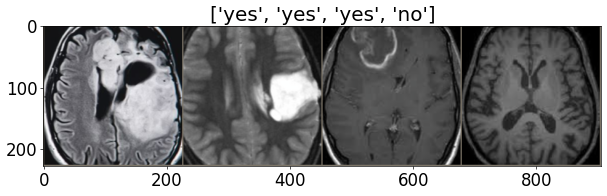

[Test #59] Loss: 0.0334 Acc: 98.6667% Time: 0.2247s


In [23]:
import matplotlib.pyplot as plt
import torchvision

class_names = ['no', 'yes']

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
##Testing
model.eval()
start_time = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if i == 0:
            print('======>RESULTS<======')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
          format(epoch, epoch_loss, epoch_acc, time.time() - start_time))